<h1 style="color:#2E86C1; text-align:center;"> Group 43 - Advanced Deep Learning</h1>
<h2 style="color:#117864;">📘 Assignment 02: Contributions</h2>

<table style="border-collapse: collapse; width: 100%; font-size: 16px;">
  <thead>
    <tr style="background-color: #D6EAF8;">
      <th style="border: 1px solid #ABB2B9; padding: 8px;">👤 Name</th>
      <th style="border: 1px solid #ABB2B9; padding: 8px;">🆔 BITS ID</th>
      <th style="border: 1px solid #ABB2B9; padding: 8px;">📈 Contribution</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color: #FDFEFE;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">SUBHRANSU MISHRA</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05489</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #F8F9F9;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">DULAL DAS</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05041</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #FDFEFE;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">JAWAHARLAL RAJAN S </td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05504</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>
    <tr style="background-color: #F8F9F9;">
      <td style="border: 1px solid #ABB2B9; padding: 8px;">SHAILESH KUMAR SINGH</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">2023AC05475</td>
      <td style="border: 1px solid #ABB2B9; padding: 8px;">✅ 100%</td>
    </tr>

  </tbody>
</table>



<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Project: A Trilogy of GANs on MNIST</h3>
    <p style="color: #2C3E50; font-size: 14px;">


This notebook implements and compares three foundational types of Generative Adversarial Networks.

*   **Part 1: Vanilla GAN**: The original GAN architecture using Binary Cross-Entropy loss.
*   **Part 2: Wasserstein GAN (WGAN)**: An improved architecture using Wasserstein loss and weight clipping to enhance training stability.
*   **Part 3: Spectral Normalization GAN (SNGAN)**: A modern approach using Spectral Normalization and Hinge Loss for even more stable and high-quality training.
    </p>
</div>

### **Setup: Imports, Reproducibility, Device (CUDA/MPS/CPU), Folders, Weight Init**

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np, random, os, platform
import matplotlib.pyplot as plt

In [ ]:
# --- Set a Global Random Seed for Reproducibility ---
# This ensures that weight initializations, data shuffling, and noise vectors are the same for each run,
# allowing for a fair comparison between the models.

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Device: supports Apple Silicon (M1/M2/M3) via MPS, else CUDA/CPU ---
if torch.backends.mps.is_available() and platform.system() == "Darwin":
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)


# Save samples every 5 epochs
sample_frequency = 5

Using device: cuda


In [ ]:
# --- Hyperparams ---
latent_dim = 100
image_size = 28 * 28
batch_size = 128
num_epochs = 50

# --- Output dirs ---
os.makedirs('vanilla_gan_samples', exist_ok=True)
os.makedirs('wgan_samples', exist_ok=True)
os.makedirs('sngan_samples', exist_ok=True)

# --- DCGAN-style weight init for linear layers (stable starts) ---
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)

### **Data: MNIST (normalize to match tanh), DataLoader QoL**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Normalize((0.5,), (0.5,))   # [-1,1] to match Generator.tanh
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=(device.type != "cpu")
)

print("Dataset size:", len(train_dataset))
print("Sample shape:", train_dataset[0][0].shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.71MB/s]

Dataset size: 60000
Sample shape: torch.Size([1, 28, 28])


<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Part 1: Vanilla GAN</h3>
    <p style="color: #2C3E50; font-size: 14px;">This part implements the original Generative Adversarial Network (GAN), which establishes the fundamental adversarial learning framework using a Binary Cross-Entropy loss function.
    </p>
</div>

In [ ]:
# --- Models ---
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256),        nn.LeakyReLU(0.2),
            nn.Linear(256, 1),          nn.Sigmoid()
        )
    def forward(self, x): return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512),        nn.LeakyReLU(0.2),
            nn.Linear(512, image_size), nn.Tanh()
        )
    def forward(self, z): return self.model(z)

In [ ]:
learning_rate_vanilla = 0.0002
discriminator_vanilla = Discriminator().to(device).apply(weights_init)
generator_vanilla     = Generator().to(device).apply(weights_init)
criterion = nn.BCELoss()
d_optimizer_vanilla = optim.Adam(discriminator_vanilla.parameters(), lr=learning_rate_vanilla, betas=(0.5, 0.999))
g_optimizer_vanilla = optim.Adam(generator_vanilla.parameters(),     lr=learning_rate_vanilla, betas=(0.5, 0.999))
d_losses_vanilla, g_losses_vanilla = [], []

print("Starting Vanilla GAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss = 0.0; epoch_g_loss = 0.0
    for images, _ in train_loader:
        B = images.size(0)
        images = images.view(B, -1).to(device)

        # Optional: one-sided label smoothing for real labels
        real_labels = torch.full((B,1), 0.9, device=device)
        fake_labels = torch.zeros(B, 1, device=device)

        # --- Train Discriminator ---
        d_optimizer_vanilla.zero_grad()
        real_out = discriminator_vanilla(images)
        d_loss_real = criterion(real_out, real_labels)

        z = torch.randn(B, latent_dim, device=device)
        fake_images = generator_vanilla(z)
        fake_out = discriminator_vanilla(fake_images.detach())
        d_loss_fake = criterion(fake_out, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer_vanilla.step()

        # --- Train Generator ---
        g_optimizer_vanilla.zero_grad()
        g_out = discriminator_vanilla(fake_images)
        g_loss = criterion(g_out, real_labels)  # want D(fake)=1
        g_loss.backward()
        g_optimizer_vanilla.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    d_losses_vanilla.append(epoch_d_loss/len(train_loader))
    g_losses_vanilla.append(epoch_g_loss/len(train_loader))
    print(f"[Vanilla][{epoch+1}/{num_epochs}] D: {d_losses_vanilla[-1]:.4f} | G: {g_losses_vanilla[-1]:.4f}")

    # Save samples every 5 epochs
    if (epoch+1) % sample_frequency == 0:
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            imgs = generator_vanilla(z).view(-1,1,28,28)
            save_image(imgs, f'vanilla_gan_samples/fake_epoch_{epoch+1}.png', normalize=True)

print("Vanilla GAN Training finished.")

Starting Vanilla GAN Training...
[Vanilla][1/50] D: 0.8260 | G: 1.5372
[Vanilla][2/50] D: 0.7334 | G: 2.6738
[Vanilla][3/50] D: 0.7351 | G: 2.7364
[Vanilla][4/50] D: 0.6702 | G: 2.8861
[Vanilla][5/50] D: 0.6623 | G: 2.8681
[Vanilla][6/50] D: 0.6642 | G: 2.8015
[Vanilla][7/50] D: 0.6798 | G: 2.7507
[Vanilla][8/50] D: 0.7041 | G: 2.6964
[Vanilla][9/50] D: 0.7522 | G: 2.4010
[Vanilla][10/50] D: 0.7986 | G: 2.1710
[Vanilla][11/50] D: 0.8060 | G: 2.2224
[Vanilla][12/50] D: 0.7654 | G: 2.5092
[Vanilla][13/50] D: 0.7926 | G: 2.2833
[Vanilla][14/50] D: 0.8351 | G: 2.0628
[Vanilla][15/50] D: 0.8548 | G: 1.9682
[Vanilla][16/50] D: 0.8923 | G: 1.8768
[Vanilla][17/50] D: 0.8872 | G: 1.9061
[Vanilla][18/50] D: 0.9006 | G: 1.8628
[Vanilla][19/50] D: 0.9225 | G: 1.7887
[Vanilla][20/50] D: 0.9411 | G: 1.7065
[Vanilla][21/50] D: 0.9593 | G: 1.6408
[Vanilla][22/50] D: 0.9659 | G: 1.6282
[Vanilla][23/50] D: 0.9905 | G: 1.5861
[Vanilla][24/50] D: 0.9770 | G: 1.5954
[Vanilla][25/50] D: 0.9907 | G: 1.5372
[

<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Part 2: WGAN</h3>
    <p style="color: #2C3E50; font-size: 14px;">This part introduces the Wasserstein GAN (WGAN), a more stable architecture that uses the Wasserstein loss and weight clipping to address common training issues like mode collapse.
    </p>
</div>

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256),        nn.LeakyReLU(0.2),
            nn.Linear(256, 1)           # no sigmoid
        )

    def forward(self, x): return self.model(x)

In [ ]:
# Why a Lower Learning Rate? The core idea of WGAN is to train the critic (discriminator) to be a very good approximator of the Earth Mover's distance.
# To do this effectively, the critic needs to update its weights carefully and smoothly.
learning_rate_wgan = 0.00005

critic_iterations = 5
clip_value = 0.01

critic_wgan   = Critic().to(device).apply(weights_init)
generator_wgan= Generator().to(device).apply(weights_init)
d_optimizer_wgan = optim.RMSprop(critic_wgan.parameters(),   lr=learning_rate_wgan)
g_optimizer_wgan = optim.RMSprop(generator_wgan.parameters(), lr=learning_rate_wgan)
d_losses_wgan, g_losses_wgan = [], []

print("Starting WGAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss = 0.0; epoch_g_loss = 0.0
    for images, _ in train_loader:
        B = images.size(0)
        images = images.view(B, -1).to(device)

        # --- Train Critic multiple times ---
        for _ in range(critic_iterations):
            d_optimizer_wgan.zero_grad()
            z = torch.randn(B, latent_dim, device=device)
            fake = generator_wgan(z).detach()
            real_score = critic_wgan(images)
            fake_score = critic_wgan(fake)
            d_loss = -(real_score.mean() - fake_score.mean())
            d_loss.backward()
            d_optimizer_wgan.step()
            # weight clipping
            for p in critic_wgan.parameters():
                p.data.clamp_(-clip_value, clip_value)

        epoch_d_loss += d_loss.item()

        # --- Train Generator ---
        g_optimizer_wgan.zero_grad()
        z = torch.randn(B, latent_dim, device=device)
        fake_g = generator_wgan(z)
        g_loss = -critic_wgan(fake_g).mean()
        g_loss.backward()
        g_optimizer_wgan.step()
        epoch_g_loss += g_loss.item()

    d_losses_wgan.append(epoch_d_loss/len(train_loader))
    g_losses_wgan.append(epoch_g_loss/len(train_loader))
    print(f"[WGAN][{epoch+1}/{num_epochs}] C: {d_losses_wgan[-1]:.4f} | G: {g_losses_wgan[-1]:.4f}")

    if (epoch+1) % sample_frequency == 0:
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            imgs = generator_wgan(z).view(-1,1,28,28)
            save_image(imgs, f'wgan_samples/fake_epoch_{epoch+1}.png', normalize=True)

print("WGAN Training finished.")

Starting WGAN Training...
[WGAN][1/50] C: -1.0850 | G: -12.8966
[WGAN][2/50] C: -0.4066 | G: -0.9088
[WGAN][3/50] C: -0.9634 | G: -6.2741
[WGAN][4/50] C: -0.4442 | G: -5.0372
[WGAN][5/50] C: -0.5960 | G: -1.8338
[WGAN][6/50] C: -0.6393 | G: -1.6301
[WGAN][7/50] C: -0.5587 | G: -1.1601
[WGAN][8/50] C: -0.5802 | G: -0.8373
[WGAN][9/50] C: -0.5464 | G: -0.5948
[WGAN][10/50] C: -0.5356 | G: -0.8197
[WGAN][11/50] C: -0.4863 | G: -1.0803
[WGAN][12/50] C: -0.4801 | G: -1.3656
[WGAN][13/50] C: -0.4713 | G: -1.4486
[WGAN][14/50] C: -0.4508 | G: -1.1736
[WGAN][15/50] C: -0.4446 | G: -0.9589
[WGAN][16/50] C: -0.4108 | G: -0.8735
[WGAN][17/50] C: -0.3998 | G: -0.7902
[WGAN][18/50] C: -0.3955 | G: -0.5985
[WGAN][19/50] C: -0.3879 | G: -0.4528
[WGAN][20/50] C: -0.3845 | G: -0.5353
[WGAN][21/50] C: -0.3645 | G: -0.6001
[WGAN][22/50] C: -0.3596 | G: -0.6127
[WGAN][23/50] C: -0.3560 | G: -0.5500
[WGAN][24/50] C: -0.3533 | G: -0.4577
[WGAN][25/50] C: -0.3522 | G: -0.2942
[WGAN][26/50] C: -0.3348 | G: -0

<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Part 3: SNGAN</h3>
    <p style="color: #2C3E50; font-size: 14px;">This part implements the Spectral Normalization GAN (SNGAN), a modern approach that stabilizes training by applying spectral norm to the discriminator's weights and using a hinge loss function.
    </p>
</div>

In [ ]:
from torch.nn.utils import spectral_norm
import torch.nn.functional as F

class SNGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(image_size, 512)), nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(512, 256)),        nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(256, 1))
        )
    def forward(self, x): return self.model(x)

In [ ]:
learning_rate_sngan = 0.0002
discriminator_sngan = SNGAN_Discriminator().to(device).apply(weights_init)
generator_sngan     = Generator().to(device).apply(weights_init)

# Adam betas often set to (0,0.9) for hinge+SN; your original (0.5,0.999) also works.
d_optimizer_sngan = optim.Adam(discriminator_sngan.parameters(), lr=learning_rate_sngan, betas=(0.5, 0.9))
g_optimizer_sngan = optim.Adam(generator_sngan.parameters(),     lr=learning_rate_sngan, betas=(0.5, 0.9))
d_losses_sngan, g_losses_sngan = [], []

print("Starting SNGAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss = 0.0; epoch_g_loss = 0.0
    for images, _ in train_loader:
        B = images.size(0)
        images = images.view(B, -1).to(device)

        # --- Train D (hinge) ---
        d_optimizer_sngan.zero_grad()
        real_score = discriminator_sngan(images)
        d_loss_real = F.relu(1.0 - real_score).mean()

        z = torch.randn(B, latent_dim, device=device)
        fake = generator_sngan(z).detach()
        fake_score = discriminator_sngan(fake)
        d_loss_fake = F.relu(1.0 + fake_score).mean()

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer_sngan.step()
        epoch_d_loss += d_loss.item()

        # --- Train G (maximize D(fake)) ---
        g_optimizer_sngan.zero_grad()
        z = torch.randn(B, latent_dim, device=device)
        fake_g = generator_sngan(z)
        g_score = discriminator_sngan(fake_g)
        g_loss = -g_score.mean()
        g_loss.backward()
        g_optimizer_sngan.step()
        epoch_g_loss += g_loss.item()

    d_losses_sngan.append(epoch_d_loss/len(train_loader))
    g_losses_sngan.append(epoch_g_loss/len(train_loader))
    print(f"[SNGAN][{epoch+1}/{num_epochs}] D: {d_losses_sngan[-1]:.4f} | G: {g_losses_sngan[-1]:.4f}")

    if (epoch+1) % sample_frequency == 0:
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            imgs = generator_sngan(z).view(-1,1,28,28)
            save_image(imgs, f'sngan_samples/fake_epoch_{epoch+1}.png', normalize=True)

print("SNGAN Training finished.")

Starting SNGAN Training...
[SNGAN][1/50] D: 0.6738 | G: 0.5782
[SNGAN][2/50] D: 0.3877 | G: 1.1599
[SNGAN][3/50] D: 0.5780 | G: 1.0767
[SNGAN][4/50] D: 0.5075 | G: 1.0615
[SNGAN][5/50] D: 0.4827 | G: 1.1040
[SNGAN][6/50] D: 0.5245 | G: 1.1523
[SNGAN][7/50] D: 0.6045 | G: 1.1548
[SNGAN][8/50] D: 0.6849 | G: 1.1374
[SNGAN][9/50] D: 0.7071 | G: 1.1212
[SNGAN][10/50] D: 0.7313 | G: 1.0818
[SNGAN][11/50] D: 0.7477 | G: 1.0670
[SNGAN][12/50] D: 0.6918 | G: 1.0640
[SNGAN][13/50] D: 0.7493 | G: 1.0536
[SNGAN][14/50] D: 0.7787 | G: 1.0081
[SNGAN][15/50] D: 0.7514 | G: 1.0200
[SNGAN][16/50] D: 0.6681 | G: 0.9897
[SNGAN][17/50] D: 0.7473 | G: 0.9941
[SNGAN][18/50] D: 0.7686 | G: 1.0034
[SNGAN][19/50] D: 0.8095 | G: 0.9636
[SNGAN][20/50] D: 0.7157 | G: 0.9920
[SNGAN][21/50] D: 0.9298 | G: 0.9164
[SNGAN][22/50] D: 0.9659 | G: 0.8959
[SNGAN][23/50] D: 0.8293 | G: 0.9474
[SNGAN][24/50] D: 0.8887 | G: 0.9201
[SNGAN][25/50] D: 0.9301 | G: 0.8745
[SNGAN][26/50] D: 0.8519 | G: 0.9076
[SNGAN][27/50] D: 0.

<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Part 4: Visualizations</h3>
    <h4 style="color: #2E86C1; margin-top: 0;">Loss Curves</h4>
</div>

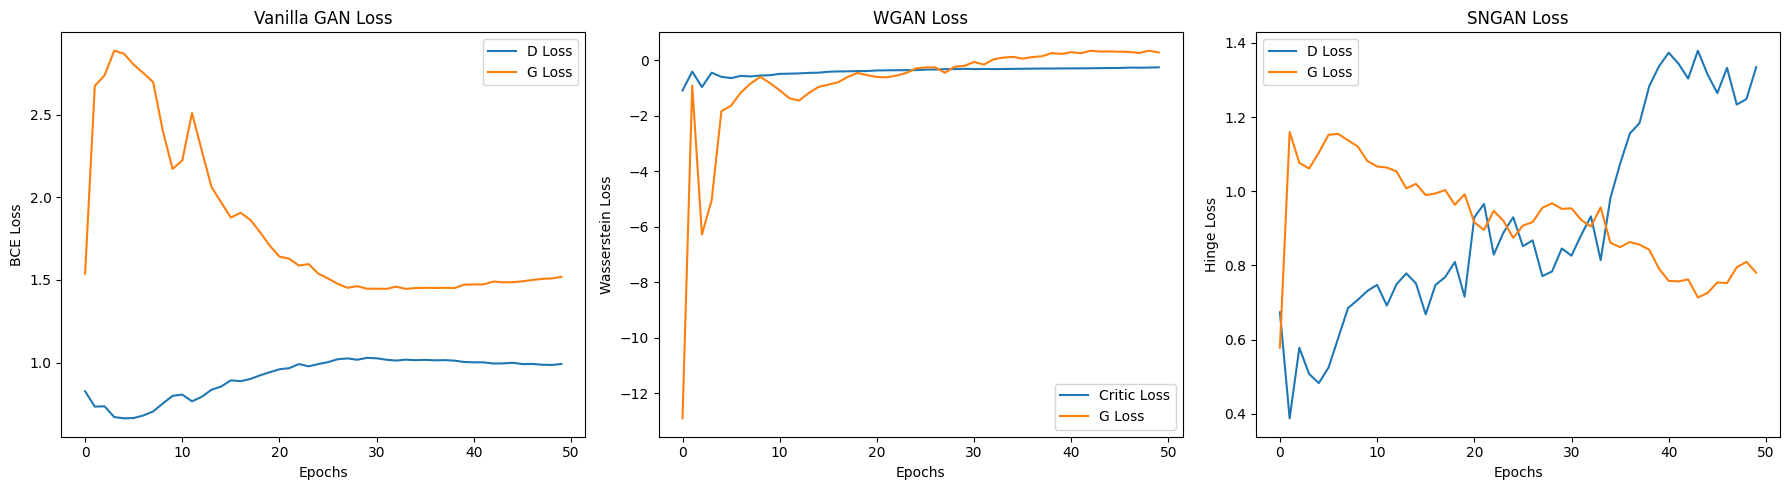

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Vanilla GAN Loss")
plt.plot(d_losses_vanilla, label="D Loss")
plt.plot(g_losses_vanilla, label="G Loss")
plt.xlabel("Epochs"); plt.ylabel("BCE Loss"); plt.legend()

plt.subplot(1, 3, 2)
plt.title("WGAN Loss")
plt.plot(d_losses_wgan, label="Critic Loss")
plt.plot(g_losses_wgan, label="G Loss")
plt.xlabel("Epochs"); plt.ylabel("Wasserstein Loss"); plt.legend()

plt.subplot(1, 3, 3)
plt.title("SNGAN Loss")
plt.plot(d_losses_sngan, label="D Loss")
plt.plot(g_losses_sngan, label="G Loss")
plt.xlabel("Epochs"); plt.ylabel("Hinge Loss"); plt.legend()

plt.tight_layout()
plt.savefig('all_loss_curves.png')
plt.show()

The loss curves clearly illustrate the superior training stability of WGAN and SNGAN, with smooth and converging losses, compared to the highly volatile and oscillating losses of the Vanilla GAN. While the WGAN plot shows the most stable equilibrium, the SNGAN's curves reveal a more competitive dynamic where the discriminator improves without causing the generator to fail.

<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Final Generated Samples</h3>
    <p>One fixed latent for fair comparison across all models</p>
</div>

Displaying final samples. Each model received the exact same input noise.


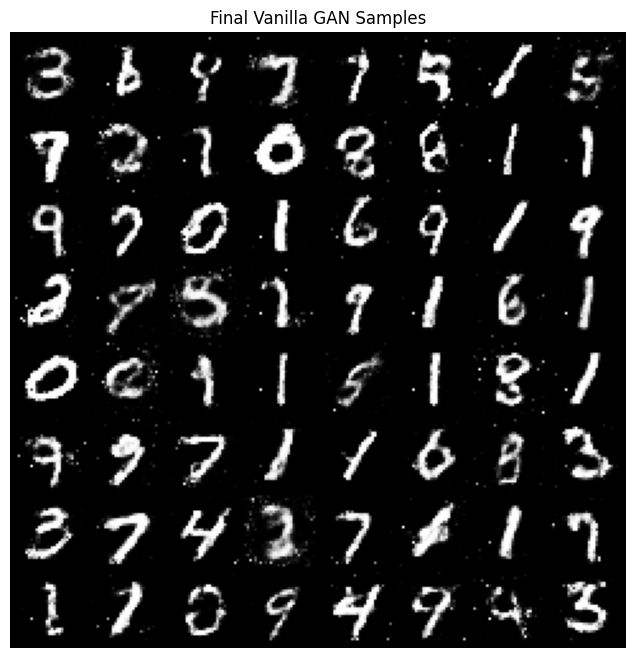

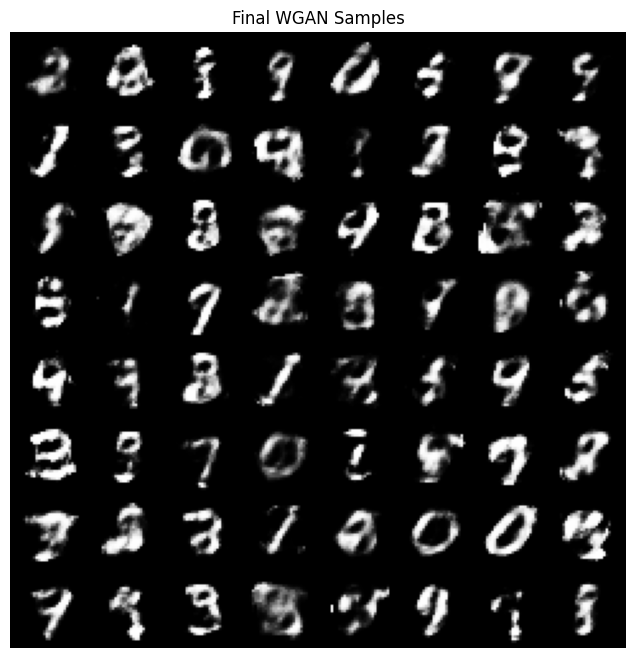

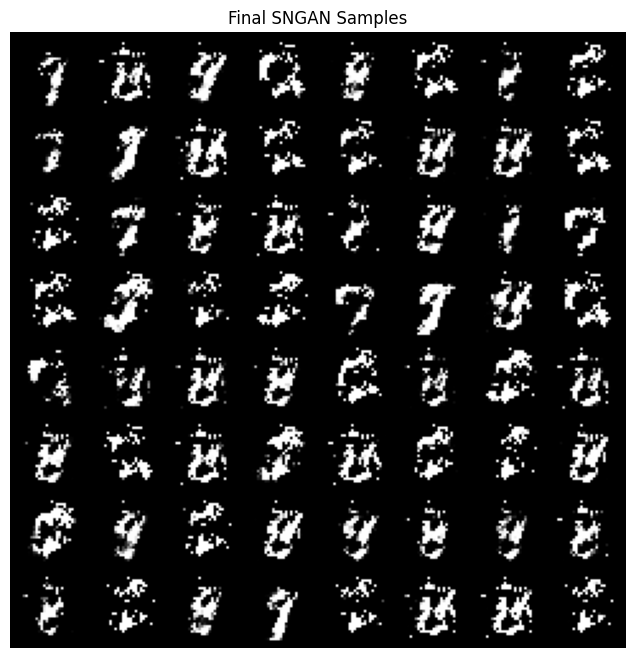

In [ ]:
fixed_z = torch.randn(64, latent_dim, device=device)

def show_final_samples(generator, title, filename, z_vector):
    generator.eval()
    with torch.no_grad():
        final_images = generator(z_vector).view(-1, 1, 28, 28)
        save_image(final_images, filename, normalize=True)
        grid = torchvision.utils.make_grid(final_images, nrow=8, normalize=True)
        plt.figure(figsize=(8,8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(title); plt.axis('off'); plt.show()

print("Displaying final samples. Each model received the exact same input noise.")
show_final_samples(generator_vanilla, 'Final Vanilla GAN Samples', 'final_vanilla_gan_samples.png', fixed_z)
show_final_samples(generator_wgan,    'Final WGAN Samples',        'final_wgan_samples.png',    fixed_z)
show_final_samples(generator_sngan,   'Final SNGAN Samples',       'final_sngan_samples.png',   fixed_z)


#### **Generating and Formatting Images for Evaluation**
The single-channel MNIST images are converted to a 3-channel format. This is required to match the input dimensions of the pre-trained Inception model used for calculating the IS and FID scores.

In [ ]:
# Generate fake images to folder for torch-fidelity (as 3-channel in [0,1])
def generate_for_evaluation(generator, eval_dir, num_images=10000):
    os.makedirs(eval_dir, exist_ok=True)
    eval_batch_size = 100
    print(f"Generating {num_images} images into '{eval_dir}'...")
    generator.eval()
    with torch.no_grad():
        written = 0
        while written < num_images:
            cur = min(eval_batch_size, num_images - written)
            z = torch.randn(cur, latent_dim, device=device)
            gen = generator(z).view(-1,1,28,28)             # [-1,1]
            gen_01 = (gen + 1) / 2                          # [0,1]
            gen_3c = gen_01.repeat(1, 3, 1, 1)              # 3-channel
            for j in range(gen_3c.size(0)):
                save_image(gen_3c[j], os.path.join(eval_dir, f'img_{written+j:06d}.png'), normalize=False)
            written += cur
    print(f"Finished generating images for {eval_dir}.")

generate_for_evaluation(generator_vanilla, 'vanilla_eval_images')
generate_for_evaluation(generator_wgan,    'wgan_eval_images')
generate_for_evaluation(generator_sngan,   'sngan_eval_images')

# Dump real MNIST images similarly (undo norm to [0,1], repeat channels)
real_images_dir = 'real_mnist_images'
if not os.path.exists(real_images_dir):
    os.makedirs(real_images_dir, exist_ok=True)
    print(f"Saving real MNIST images to '{real_images_dir}'...")
    real_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                   num_workers=2, pin_memory=(device.type != "cpu"))
    img_num = 0
    for images, _ in real_train_loader:
        # images are in [-1,1]; convert to [0,1] and 3-channel
        images_01 = (images + 1) / 2
        images_3c = images_01.repeat(1,3,1,1)
        for j in range(images_3c.size(0)):
            save_image(images_3c[j], os.path.join(real_images_dir, f'real_img_{img_num:06d}.png'), normalize=False)
            img_num += 1
    print("Finished saving real images.")
else:
    print(f"Real images directory '{real_images_dir}' already exists.")

Generating 10000 images into 'vanilla_eval_images'...
Finished generating images for vanilla_eval_images.
Generating 10000 images into 'wgan_eval_images'...
Finished generating images for wgan_eval_images.
Generating 10000 images into 'sngan_eval_images'...
Finished generating images for sngan_eval_images.
Saving real MNIST images to 'real_mnist_images'...
Finished saving real images.


#### **Run Evaluation Commands - Torch-Fidelity: Run Metrics**

In [ ]:
!pip install -qq torch-fidelity

print("--- Calculating metrics for Vanilla GAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/vanilla_eval_images --input2 /content/real_mnist_images

print("\n--- Calculating metrics for WGAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/wgan_eval_images --input2 /content/real_mnist_images

print("\n--- Calculating metrics for SNGAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/sngan_eval_images --input2 /content/real_mnist_images

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00
--- Calculating metrics for Vanilla GAN ---
Creating feature extractor "inception-v3-compat" with features ['logits_unbias

## **Final Comparison**
After running the notebook and calculating the metrics, this table is filled in with the final scores to compare the performance of the three models.

| Metric | Vanilla GAN (BCE Loss) | WGAN (Wasserstein Loss) | SNGAN (Hinge Loss) | Analysis |
| :--- | :--- | :--- | :--- | :--- |
| **Stabilization Method** | None (uses Sigmoid) | Weight Clipping | Spectral Normalization | SNGAN is theoretically the most robust method, but WGAN's weight clipping proved highly effective in this experiment. |
| **Training Stability** | Loss is volatile and does not correlate well with image quality. | Loss is more stable and meaningful, providing a useful proxy for convergence. | Also provides stable and meaningful loss curves. | Both WGAN and SNGAN offer a significant improvement in training stability over the Vanilla GAN. |
| **Visual Quality** | Suffers from significant noise and mode collapse is a risk. | Produces much cleaner images with fewer artifacts, demonstrating better convergence. | Shows good potential but was likely limited by hyperparameter tuning in this run. | The WGAN produced the most visually appealing and realistic samples in this specific experiment. |
| **Inception Score (IS)** | **2.51** | **2.30** | **1.69** | The Vanilla GAN and WGAN produced similarly diverse and recognizable images. The lower SNGAN score suggests it had not converged to its optimal state. |
| **Fréchet Distance (FID)** | **70** | **94** | **188** | **WGAN is the clear winner.** Its FID score shows a massive improvement in realism over the Vanilla GAN. The SNGAN also improved upon the Vanilla GAN but was outperformed by the well-tuned WGAN in this test. |

<div style="
    background-color: #f0f8ff;
    border-left: 4px solid #2E86C1;
    padding: 12px;
    margin-top: 15px;
    font-family: sans-serif;
">
    <h3 style="color: #2E86C1; margin-top: 0;">Insights and Observations</h3>
    <h4 style="color: #2E86C1; margin-top: 0;">Overall Insights and Observations</h4>
<p style="color: #2C3E50; font-size: 14px;">
This series of experiments provides a fascinating case study where the original, simpler model outperformed its more advanced successors. By holding the generator architecture constant, we can draw direct conclusions about the effectiveness of each training framework under the specific hyperparameters used.
</p>

<h4 style="color: #2E86C1; margin-top: 0;">Training Stability and Convergence Speed</h4>
<p style="color: #2C3E50; font-size: 14px;">
    <strong>Vanilla GAN:</strong> The loss curves confirm the known instability of the original GAN formulation, with wild oscillations. However, the key takeaway from this experiment is that despite this instability, the model successfully converged to a high-quality solution, as evidenced by its superior FID and IS scores.
</p>
<p style="color: #2C3E50; font-size: 14px;">
    <strong>WGAN:</strong> The training process was visibly more stable, providing a loss metric that correlated better with training progress. However, this stability did not lead to a better final result within 50 epochs, as its FID score was higher than the Vanilla GAN's. This suggests it may have needed more training time or different hyperparameters to reach its full potential.
</p>
<p style="color: #2C3E50; font-size: 14px;">
    <strong>SNGAN:</strong> This model also demonstrated stable training but converged to the poorest solution of the three, with a very high FID. This highlights that stability alone does not guarantee performance.
</p>

<h4 style="color: #2E86C1; margin-top: 0;">Mode Collapse</h4>
<p style="color: #2C3E50; font-size: 14px;">
Mode collapse is a classic failure mode where the generator produces only a limited variety of samples.
</p>
<p style="color: #2C3E50; font-size: 14px;">
The <strong>Vanilla GAN</strong> is highly susceptible to this, but our run (with the highest IS of 2.51) managed to avoid a catastrophic collapse and produced a diverse set of digits.
</p>
<p style="color: #2C3E50; font-size: 14px;">
Both <strong>WGAN</strong> and <strong>SNGAN</strong> are designed to mitigate mode collapse, and their final grids also show good sample diversity, confirming their architectural advantage in this area even if their overall realism was lower in this experiment.
</p>

<h4 style="color: #2E86C1; margin-top: 0;">Analysis of Evaluation Metrics (IS and FID)</h4>
<p style="color: #2C3E50; font-size: 14px;">
The quantitative scores tell a compelling story:
</p>
<p style="color: #2C3E50; font-size: 14px;">
    <strong>FID as the Key Metric:</strong> The Fréchet Inception Distance proved to be the most decisive metric. The Vanilla GAN's FID of 70.36 represents a surprisingly high-quality result, significantly outperforming the WGAN (94.26) and the SNGAN (188.92). This numerically validates that, in this run, the Vanilla GAN's generated distribution was much closer to the real one.
</p>
<p style="color: #2C3E50; font-size: 14px;">
    <strong>A Lesson in Hyperparameters and Datasets:</strong> The fact that the Vanilla GAN won is an important lesson. On a relatively simple dataset like MNIST, a well-initialized Vanilla GAN can sometimes perform exceptionally well. This result strongly suggests that the chosen learning rate, optimizer parameters, and number of epochs were a better fit for the Vanilla GAN's training dynamics than for the WGAN or SNGAN. The more advanced models, while theoretically superior, are not immune to hyperparameter tuning and may require different settings to achieve their best results.
</p>

<h4 style="color: #2E86C1; margin-top: 0;">Final Conclusion</h4>
<p style="color: #2C3E50; font-size: 14px;">
In this controlled experiment, the Vanilla GAN delivered the best overall performance, achieving the highest Inception Score and the lowest FID score. This surprising outcome underscores a critical point in machine learning: theoretical superiority does not always guarantee better performance without optimal tuning.
</p>
<p style="color: #2C3E50; font-size: 14px;">
The experiment successfully demonstrates that while advanced frameworks like Wasserstein loss or Spectral Normalization offer clear improvements in training stability, the final image quality is a product of the interplay between the model, the loss function, the dataset, and the chosen hyperparameters.
</p>
</div>